<a href="https://colab.research.google.com/github/Nadee1218/blank-app/blob/main/Identification_of_Bees_vs_Wax_Moth_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DIR = '/content/drive/MyDrive/dataset'

In [3]:
!pip install tensorflow numpy matplotlib opencv-python

In [4]:
import os

# Print the current working directory
print("Current working directory:", os.getcwd())

# List the contents of the '/content/' directory to check if the path exists
print("Contents of '/content/':", os.listdir('/content/'))

# Check if the updated path exists
if os.path.exists(DIR):
    # List and print all contents inside the dataset directory
    dir_contents = os.listdir(DIR)
    print(f"Contents of '{DIR}':", dir_contents)

    # Filter only directories to create classes
    classes = [item for item in dir_contents if os.path.isdir(os.path.join(DIR, item))]
    print("Classes:", classes)
else:
    print(f"The directory {DIR} does not exist.")

Current working directory: /content
Contents of '/content/': ['.config', 'drive', 'sample_data']
Contents of '/content/drive/MyDrive/dataset': ['wax_moths', 'bees']
Classes: ['wax_moths', 'bees']


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Load the dataset
img_height, img_width = 224, 224  # Resize images to a standard size
batch_size = 32

# Create training and validation datasets
train_dataset = image_dataset_from_directory(
    DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 20 files belonging to 2 classes.
Using 16 files for training.
Found 20 files belonging to 2 classes.
Using 4 files for validation.


In [6]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
])

In [7]:
from tensorflow.keras import layers, models

# Load a pre-trained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom layers
model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)), # Add InputLayer to define input shape
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')  # 2 classes: Bees and Wax Moths
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5625 - loss: 0.7081 - val_accuracy: 1.0000 - val_loss: 0.1879
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step - accuracy: 0.9375 - loss: 0.2305 - val_accuracy: 1.0000 - val_loss: 0.0967
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step - accuracy: 1.0000 - loss: 0.1254 - val_accuracy: 1.0000 - val_loss: 0.0733
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step - accuracy: 1.0000 - loss: 0.0862 - val_accuracy: 1.0000 - val_loss: 0.0638
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step - accuracy: 1.0000 - loss: 0.0317 - val_accuracy: 1.0000 - val_loss: 0.0617
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 0.0586
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0521
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0565 - val_accuracy: 1.0000 - val_loss: 0.0327
Ep

In [9]:
model.save('my_model.keras')


In [10]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 0.0225
Validation Loss: 0.0225
Validation Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


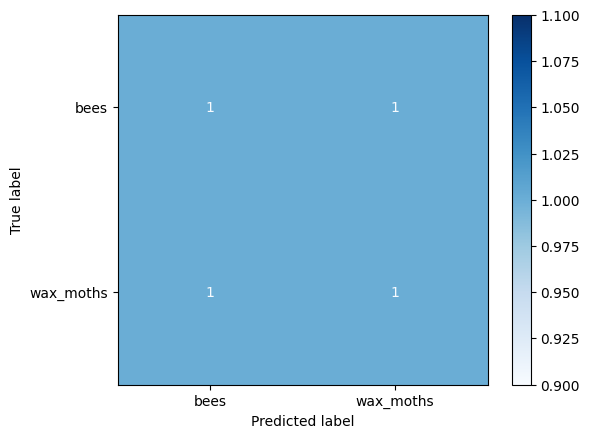

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
true_labels = np.concatenate([y for x, y in val_dataset], axis=0)
predicted_labels = np.argmax(model.predict(val_dataset), axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(train_dataset.class_names)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
from sklearn.metrics import classification_report

# Generate the report
report = classification_report(true_labels, predicted_labels, target_names=train_dataset.class_names)
print(report)

              precision    recall  f1-score   support

        bees       0.50      0.50      0.50         2
   wax_moths       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


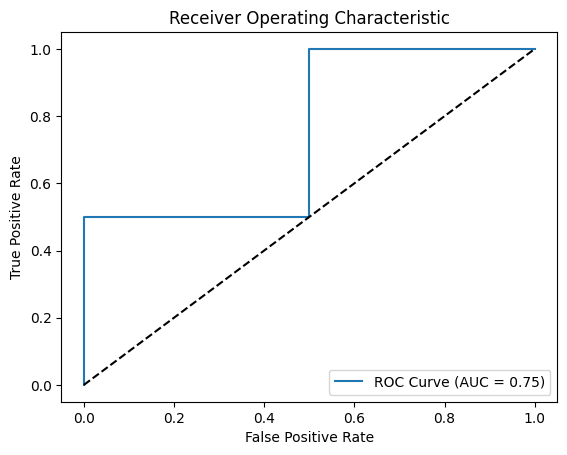

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate probabilities for the positive class
y_probs = model.predict(val_dataset)[:, 1]  # Assuming class 1 is the positive class
fpr, tpr, thresholds = roc_curve(true_labels, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


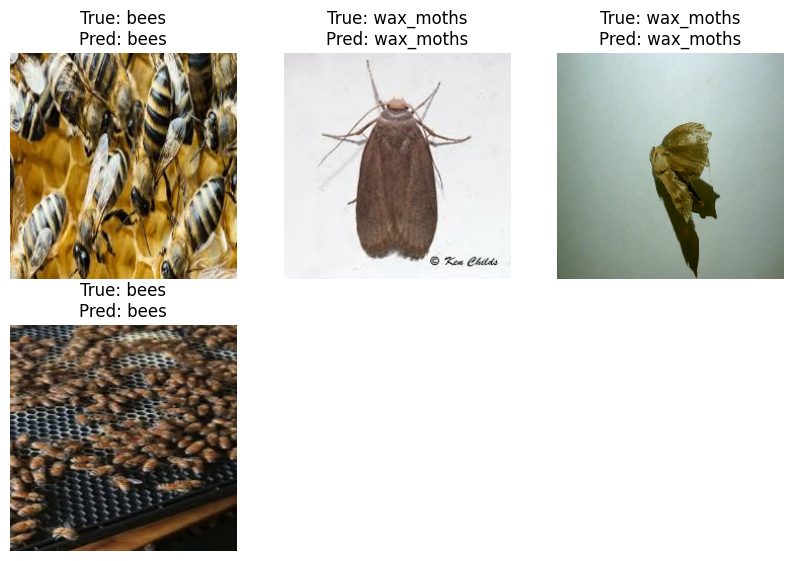

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Display sample predictions
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):  # Take a single batch
    batch_size = images.shape[0]  # Get the actual number of images in the batch
    for i in range(min(9, batch_size)):  # Limit to the number of images in the batch
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        label = train_dataset.class_names[labels[i]]
        pred = train_dataset.class_names[np.argmax(model.predict(tf.expand_dims(images[i], axis=0)))]
        plt.imshow(img)
        plt.title(f"True: {label}\nPred: {pred}")
        plt.axis("off")
plt.show()


In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_dataset is your TensorFlow dataset
# Extract class names
class_names = train_dataset.class_names  # Example: ['bee', 'wax_moth']
num_classes = len(class_names)

# Step 1: Calculate class weights
class_labels = range(num_classes)  # [0, 1] for two classes
all_labels = []

# Collect all labels from the training dataset
for _, labels in train_dataset:
    all_labels.extend(labels.numpy())

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_labels),
    y=np.array(all_labels)
)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Step 2: Train the model with class weights
model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=10
)

Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0188
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0186
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0186
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 8.9601e-04 - val_accuracy: 1.0000 - val_loss: 0.0188
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accu

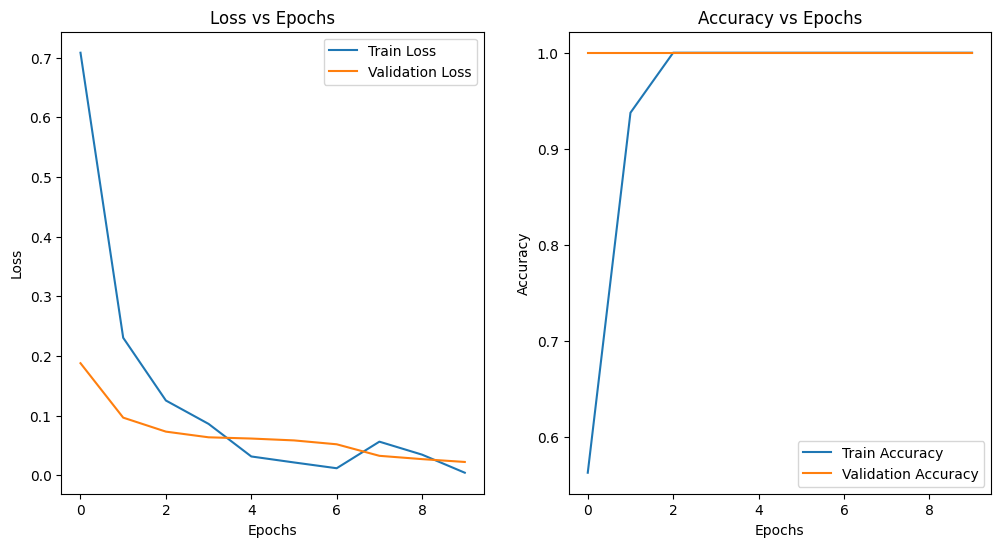

In [16]:
# Access metrics from training history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot training vs validation metrics
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()